In [ ]:
!pip install eli5 pdpbox category_encoders shap

In [2]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import shap
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [154]:
df = pd.read_csv('https://raw.githubusercontent.com/StevenMElliott/youtube-trending-classification/master/USvideos_modified.csv')
df.head()

,video_id,last_trending_date,publish_date,publish_hour,category_id,channel_title,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tag_appeared_in_title_count,tag_appeared_in_title,title,tags,description,trend_day_count,trend.publish.diff,trend_tag_highest,trend_tag_total,tags_count,subscriber
0,2kyS6SvSYSE,2017-11-20,2017-11-13,17,22,CaseyNeistat,2564903,96321,7972,22149,False,False,0,False,WE WANT TO TALK ABOUT OUR MARRIAGE,SHANtell martin,SHANTELL'S CHANNEL - https://www.youtube.com/s...,7,7,2,2,1,9086142.0
1,1ZAPwfrtAFY,2017-11-20,2017-11-13,7,24,LastWeekTonight,6109402,151250,11508,19820,False,False,0,False,The Trump Presidency: Last Week Tonight with J...,last week tonight trump presidency|last week t...,"One year after the presidential election, John...",7,7,65,69,4,5937292.0
2,5qpjK5DgCt4,2017-11-20,2017-11-12,19,23,Rudy Mancuso,5315471,187303,7278,9990,False,False,8,True,"Racist Superman | Rudy Mancuso, King Bach & Le...",racist superman|rudy|mancuso|king|bach|racist|...,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,7,8,68,426,23,4191209.0
3,puqaWrEC7tY,2017-11-20,2017-11-13,11,24,Good Mythical Morning,913268,16729,1386,2988,False,False,3,True,Nickelback Lyrics: Real or Fake?,rhett and link|gmm|good mythical morning|rhett...,Today we find out if Link is a Nickelback amat...,7,7,488,1246,28,13186408.0
4,d380meD0W0M,2017-11-19,2017-11-12,18,24,nigahiga,2819118,153395,2416,20573,False,False,1,True,I Dare You: GOING BALD!?,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,I know it's been a while since we did this sho...,6,7,488,1007,14,20563106.0


In [155]:
trend_class = pd.read_csv('https://raw.githubusercontent.com/StevenMElliott/youtube-trending-classification/master/Trending%20CrowdSourced%20Classification.csv')
t_class = trend_class.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1)
t_class = t_class.dropna()
t_class = t_class.rename(columns={'channel': 'channel_title'})
t_class.head()

,channel_title,classification
0,Saturday Night Live,TM
1,CrazyRussianHacker,YT
2,20th Century Fox,TR
3,Vox,TM
4,NFL,TM


In [156]:
t_class['classification'].value_counts()

YT    812
TM    465
MU    409
CV    255
CO    170
TR     74
Name: classification, dtype: int64

In [157]:
youtuber = t_class[t_class['classification'] == 'YT']
traditional_media = t_class[t_class['classification'] =='TM']
tm_and_yt = pd.concat([youtuber, traditional_media])
tm_and_yt.shape
tm_and_yt['classification'].value_counts()

YT    812
TM    465
Name: classification, dtype: int64

In [158]:
df = df.merge(tm_and_yt, how='left')
df.shape

(4547, 24)

In [159]:
df = df.drop(['video_id', 'last_trending_date', 'publish_date',
              'title', 'tags', 'description'], axis=1)
print(df.shape)
df.head()

(4547, 18)


,publish_hour,category_id,channel_title,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tag_appeared_in_title_count,tag_appeared_in_title,trend_day_count,trend.publish.diff,trend_tag_highest,trend_tag_total,tags_count,subscriber,classification
0,17,22,CaseyNeistat,2564903,96321,7972,22149,False,False,0,False,7,7,2,2,1,9086142.0,YT
1,7,24,LastWeekTonight,6109402,151250,11508,19820,False,False,0,False,7,7,65,69,4,5937292.0,TM
2,19,23,Rudy Mancuso,5315471,187303,7278,9990,False,False,8,True,7,8,68,426,23,4191209.0,YT
3,11,24,Good Mythical Morning,913268,16729,1386,2988,False,False,3,True,7,7,488,1246,28,13186408.0,YT
4,18,24,nigahiga,2819118,153395,2416,20573,False,False,1,True,6,7,488,1007,14,20563106.0,YT


In [160]:
# Split channels for Train and Test
channels = df['channel_title'].unique()
train_chan, test_chan = train_test_split(channels, random_state=42)

train = df[df['channel_title'].isin(train_chan)]
test = df[df['channel_title'].isin(test_chan)]
assert(len(test) + len(train) == len(df))
test.shape, train.shape, df.shape

((1030, 18), (3517, 18), (4547, 18))

In [161]:
#baseline
df['classification'].value_counts(normalize=True)

TM    0.512122
YT    0.487878
Name: classification, dtype: float64

In [162]:
#Feature Engineering
def wrangle(X):  
  #engagement column
  # note the +1's are to prevent dividing by 0 and ending the universe.
  X['Engagement Per View'] =  (X['likes'] + 
                               X['dislikes'] + 
                               X['comment_count'] + 1) / X['views']
  #possitive reception
  X['Likes Percent'] = X['likes'] / (X['likes'] + 
                                  X['dislikes'] + 1)
  
  #hard engagement - How many comments are recieved vs likes/dislikes
  X['Comments Per Click'] = X['comment_count'] / (X['likes'] + 
                                             X['dislikes'] + 1)
  #Rename the columns
  X = X.rename(columns={'publish_hour': 'Hour Published', 
                        'category_id': 'Category ID', 
                        'channel_title': 'Channel',
                        'comment_count': 'Total Comments',
                        'subscriber': 'Subcribers',
                        'views': 'Views',
                        'likes': 'Likes',
                        'dislikes': 'Dislikes',
                        'trend.publish.diff': 'Days Published Before Trending',
                        'trend_tag_total': 'Sum of Trending #'})
  
  X = X.dropna()
  return(X)

wrangled_df = wrangle(df)
test = wrangle(test)
train = wrangle(train)
wrangled_df.head()

,Hour Published,Category ID,Channel,Views,Likes,Dislikes,Total Comments,comments_disabled,ratings_disabled,tag_appeared_in_title_count,tag_appeared_in_title,trend_day_count,Days Published Before Trending,trend_tag_highest,Sum of Trending #,tags_count,Subcribers,classification,Engagement Per View,Likes Percent,Comments Per Click
0,17,22,CaseyNeistat,2564903,96321,7972,22149,False,False,0,False,7,7,2,2,1,9086142.0,YT,0.049297,0.923553,0.212371
1,7,24,LastWeekTonight,6109402,151250,11508,19820,False,False,0,False,7,7,65,69,4,5937292.0,TM,0.029885,0.929288,0.121775
2,19,23,Rudy Mancuso,5315471,187303,7278,9990,False,False,8,True,7,8,68,426,23,4191209.0,YT,0.038486,0.962592,0.051341
3,11,24,Good Mythical Morning,913268,16729,1386,2988,False,False,3,True,7,7,488,1246,28,13186408.0,YT,0.023108,0.923438,0.164937
4,18,24,nigahiga,2819118,153395,2416,20573,False,False,1,True,6,7,488,1007,14,20563106.0,YT,0.062567,0.984488,0.132037


#Model Time!

##Random Forest

In [163]:
# The 'show_made_flag' column is the target
target = 'classification'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 5000
categorical_features = cardinality[cardinality <= 5000].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [164]:
categorical_features

['Channel', 'comments_disabled', 'ratings_disabled', 'tag_appeared_in_title']

In [165]:
y_train = train['classification']
y_train.value_counts(normalize=True)

TM    0.525773
YT    0.474227
Name: classification, dtype: float64

In [166]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [167]:

#Notice the Ordinal Encoding
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train);

In [168]:
pipeline.score(X_test, y_test)

0.7893258426966292

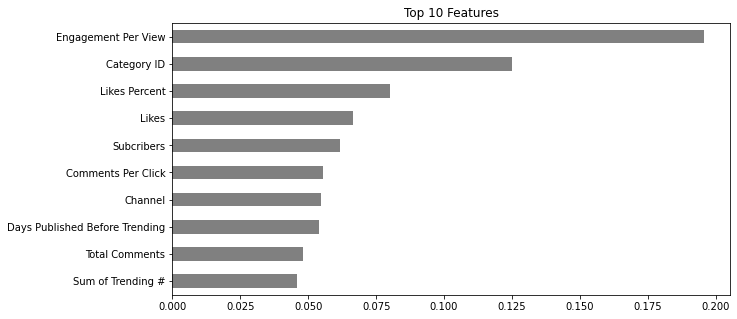

In [169]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot top 5 feature importances
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} Features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [45]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index =[f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
              columns=columns, index=index)
  return sns.heatmap(table, annot=True, fmt='d')

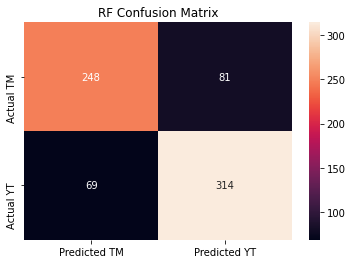

In [46]:
y_pred = pipeline.predict(X_test)
ax = plot_confusion_matrix(y_test, y_pred)

ax.set_title('RF Confusion Matrix');

In [47]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          TM       0.78      0.75      0.77       329
          YT       0.79      0.82      0.81       383

    accuracy                           0.79       712
   macro avg       0.79      0.79      0.79       712
weighted avg       0.79      0.79      0.79       712



In [48]:
test_stringless = X_test.drop(['Channel'], axis=1)
train_stringless = X_train.drop(['Channel'], axis=1)

In [49]:
test_stringless.head()

,Hour Published,Category ID,Views,Likes,Dislikes,Total Comments,tag_appeared_in_title_count,trend_day_count,Days Published Before Trending,trend_tag_highest,Sum of Trending #,tags_count,Subcribers,Engagement Per View,Likes Percent,Comments Per Click,comments_disabled,ratings_disabled,tag_appeared_in_title
15,20,28,5531707,72727,3362,14816,1,3,3,6,18,5,824219.0,0.016434,0.955802,0.194717,False,False,True
23,16,26,237111,2323,786,636,4,3,4,158,600,35,890739.0,0.015799,0.746945,0.204502,False,False,True
44,15,22,352770,4782,1838,741,3,4,6,488,1083,44,511999.0,0.020869,0.722247,0.111917,False,False,True
45,0,26,1856410,38114,2049,2768,3,4,5,29,55,17,5019780.0,0.023126,0.948959,0.068917,False,False,True
49,23,24,2374251,49509,3038,8545,6,4,7,113,527,28,16874196.0,0.025731,0.942167,0.162613,False,False,True


In [50]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(train_stringless)
X_test_processed = processor.transform(test_stringless)

eval_set = [(X_train_processed, y_train), 
            (X_test_processed, y_test)]

model = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(train_stringless, y_train);

In [51]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, cv='prefit', n_iter=2, random_state=42)

permuter.fit(test_stringless, y_test)
feature_names = test_stringless.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1201 ± 0.0098,Engagement Per View
0.0246 ± 0.0014,Likes
0.0218 ± 0.0126,Total Comments
0.0183 ± 0.0028,Days Published Before Trending
0.0063 ± 0.0014,Category ID
0.0063 ± 0.0098,Dislikes
0.0056 ± 0.0112,Likes Percent
0.0042 ± 0.0056,trend_tag_highest
0.0021 ± 0.0042,tags_count
0.0021 ± 0.0014,trend_day_count


In [52]:
mask = permuter.feature_importances_ > 0
features = train_stringless.columns[mask]
X_train = train_stringless[features]
X_test = test_stringless[features]

model = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train, y_train);

In [53]:

#Notice the Ordinal Encoding
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train);

In [54]:
pipeline.score(X_test, y_test)

0.800561797752809

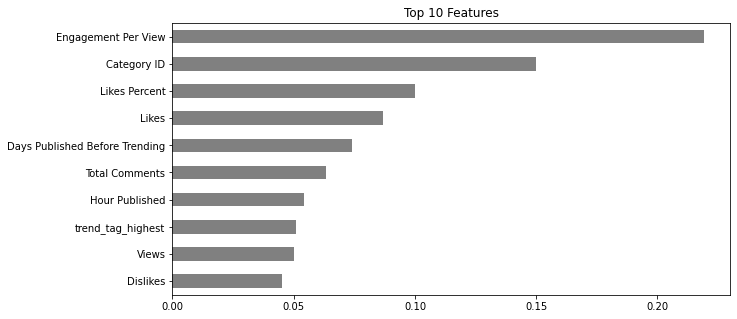

In [55]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot top 10 feature importances
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} Features')
importances.sort_values()[-n:].plot.barh(color='grey');

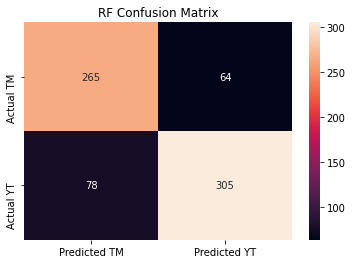

In [56]:
y_pred = pipeline.predict(X_test)
ax = plot_confusion_matrix(y_test, y_pred)

ax.set_title('RF Confusion Matrix');

##PDP Plot

In [57]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


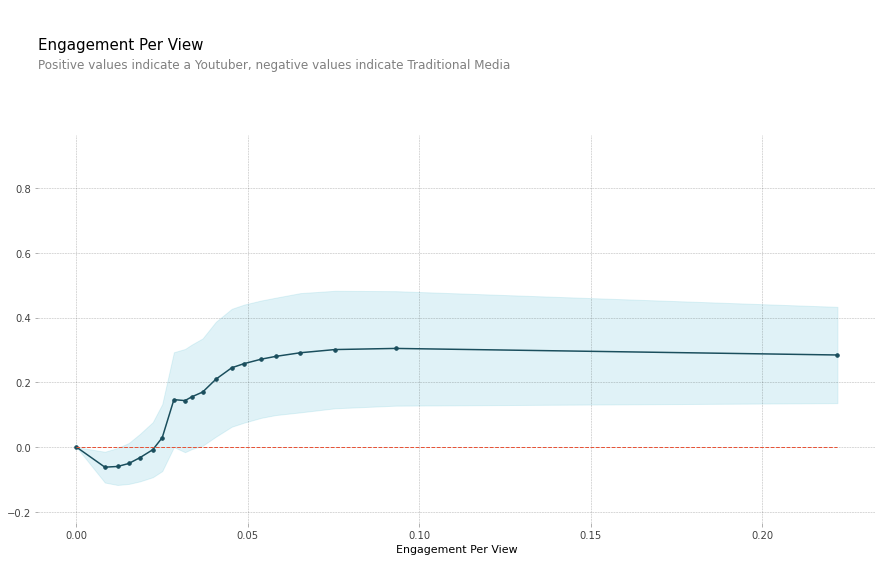

In [58]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Engagement Per View'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    percentile_range=(0,100,),
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature, 
         plot_params = {'title': 'Engagement Per View', 
                        'subtitle':'Positive values indicate a Youtuber, negative values indicate Traditional Media'});

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0828342518>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0828577400>})

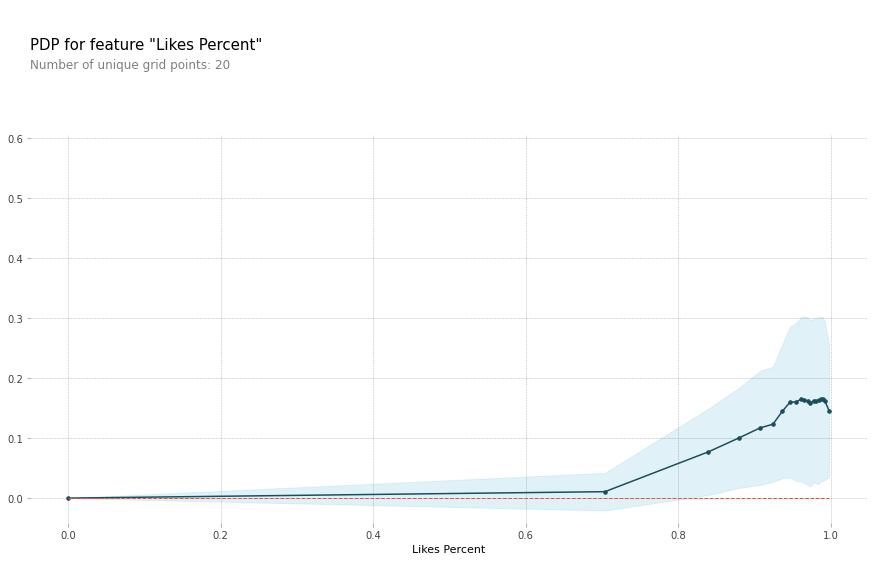

In [59]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Likes Percent'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
#     percentile_range=(50,100,),
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f082827c588>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f082838b160>})

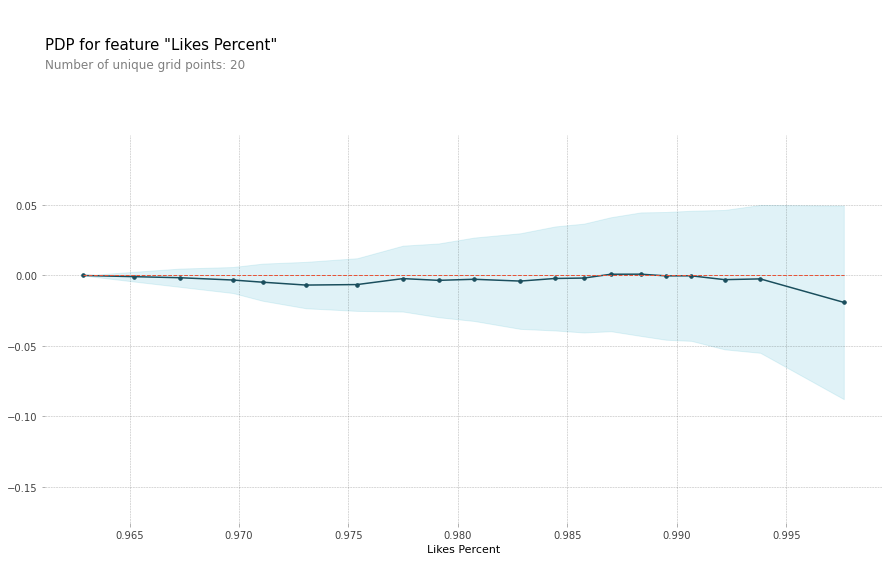

In [60]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Likes Percent'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    percentile_range=(50,100,),
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature)

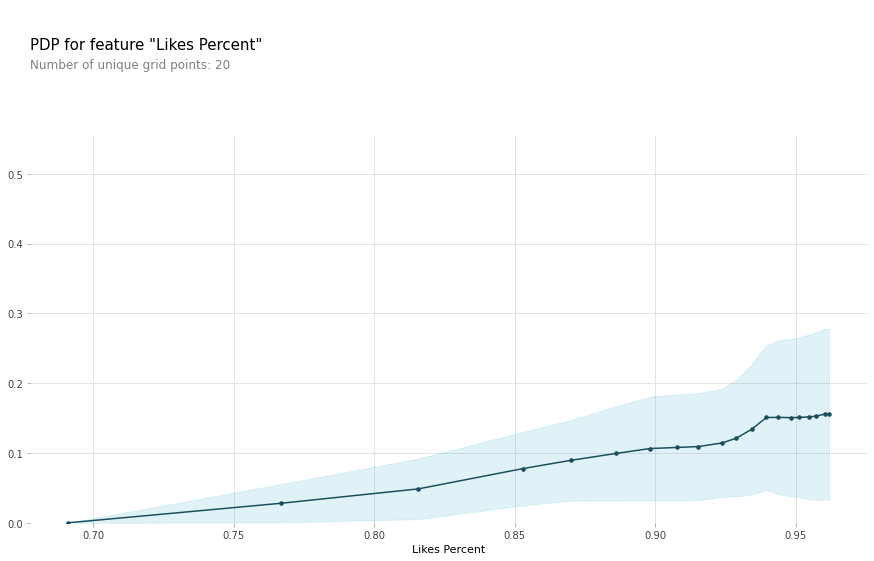

In [61]:
feature = 'Likes Percent'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    percentile_range=(5,49,),
    num_grid_points=20
)
pdp_plot(isolated, feature_name=feature);

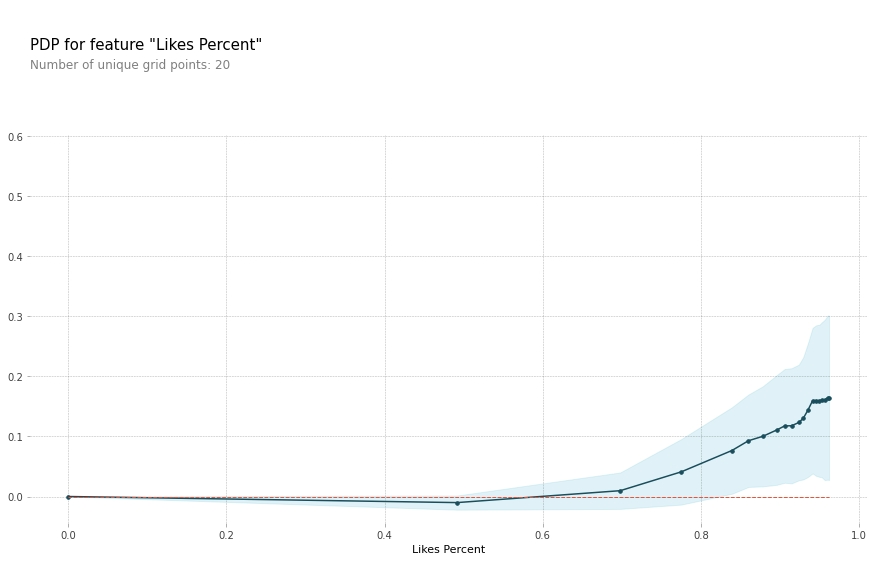

In [62]:

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    percentile_range=(0,49,),
    num_grid_points=20
)
pdp_plot(isolated, feature_name=feature);

###PDP Plot 2 features

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


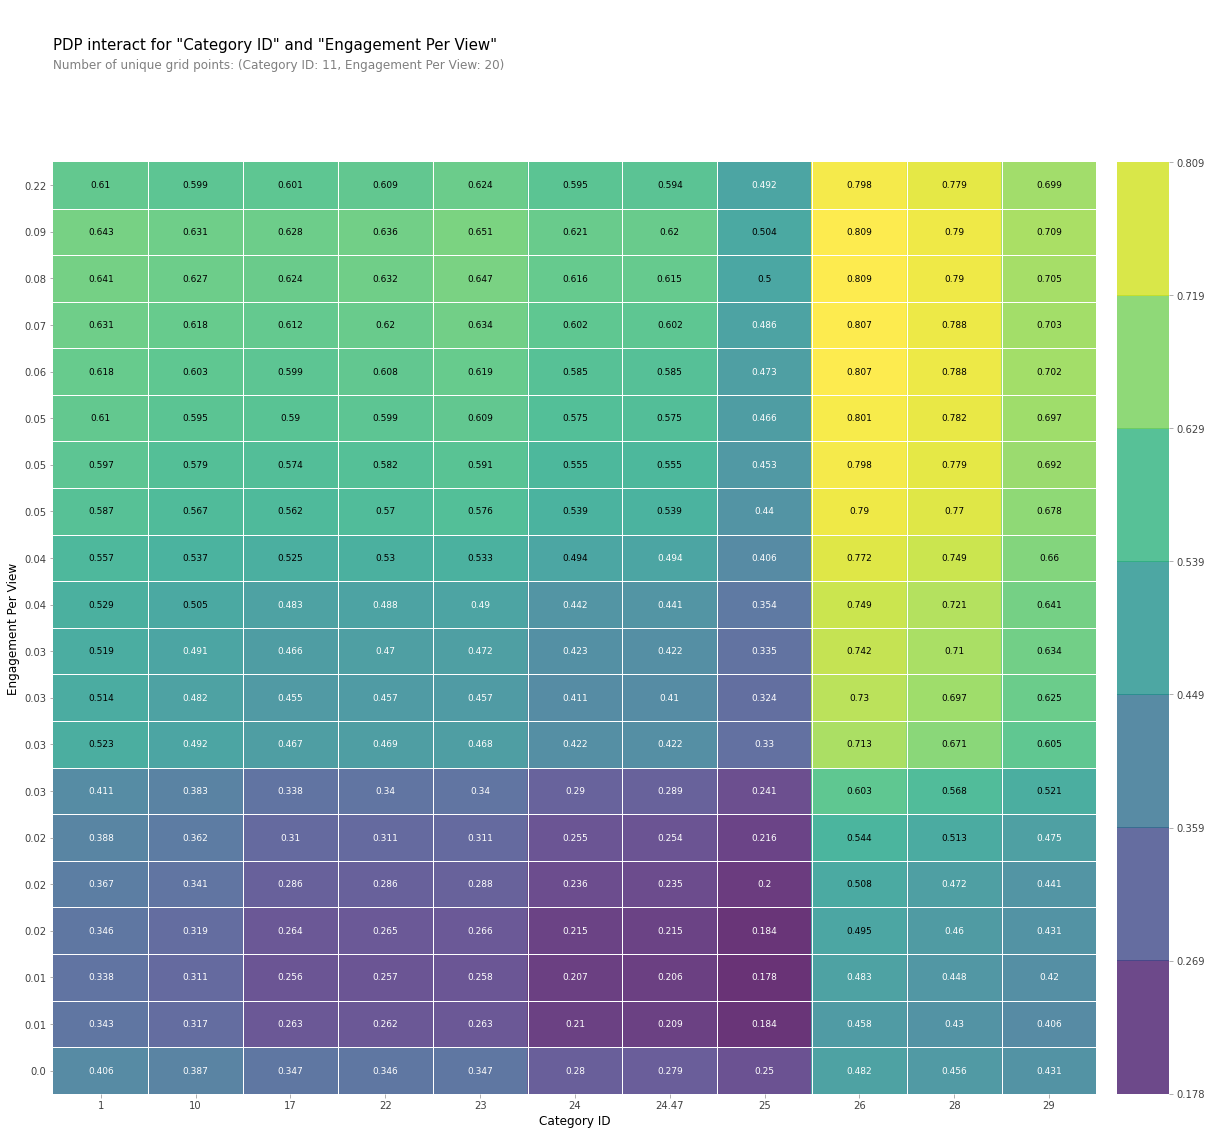

In [63]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = [ 'Category ID', 'Engagement Per View']

interaction = pdp_interact(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns,
    num_grid_points=[20,20],
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  ncols=32, figsize=[20,20], feature_names=features);

##XGBClassifier

In [64]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

eval_set = [(X_train_processed, y_train), 
            (X_test_processed, y_test)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.855672	validation_1-auc:0.774647
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.879873	validation_1-auc:0.834906
[2]	validation_0-auc:0.894065	validation_1-auc:0.840799
[3]	validation_0-auc:0.895427	validation_1-auc:0.852592
[4]	validation_0-auc:0.903552	validation_1-auc:0.847675
[5]	validation_0-auc:0.907954	validation_1-auc:0.851187
[6]	validation_0-auc:0.909535	validation_1-auc:0.853409
[7]	validation_0-auc:0.912581	validation_1-auc:0.853746
[8]	validation_0-auc:0.913185	validation_1-auc:0.850901
[9]	validation_0-auc:0.915995	validation_1-auc:0.853088
[10]	validation_0-auc:0.919459	validation_1-auc:0.860849
[11]	validation_0-auc:0.91999	validation_1-auc:0.859309
[12]	validation_0-auc:0.921277	validation_1-auc:0.860369
[13]	validation_0-auc:0.922354	validation_1-auc:0.86498
[14]	validation_0-auc:0.923545	validation_1-auc:0.86446
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [65]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.8964025808090026


In [66]:

#Notice the Ordinal Encoding
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    XGBClassifier(n_estimators=30, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train);

In [67]:
pipeline.score(X_test, y_test)

0.7865168539325843

In [68]:
pipeline.named_steps

{'ordinalencoder': OrdinalEncoder(cols=[], drop_invariant=False, handle_missing='value',
                handle_unknown='value', mapping=[], return_df=True, verbose=0),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='median', verbose=0),
 'xgbclassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=30, n_jobs=-1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1)}

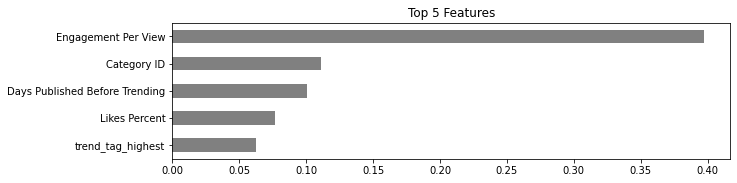

In [69]:
# Get feature importances
rf = pipeline.named_steps['xgbclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot top 5 feature importances
n = 5
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} Features')
importances.sort_values()[-n:].plot.barh(color='grey');

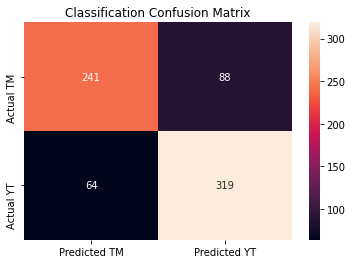

In [70]:
y_pred = pipeline.predict(X_test)
ax = plot_confusion_matrix(y_test, y_pred)

ax.set_title('Classification Confusion Matrix');

In [71]:
y_test == y_pred

15       True
23      False
44      False
45       True
49      False
        ...  
4536    False
4539     True
4541     True
4542     True
4543    False
Name: classification, Length: 712, dtype: bool

In [72]:
X_test.head(300)

,Hour Published,Category ID,Views,Likes,Dislikes,Total Comments,tag_appeared_in_title_count,trend_day_count,Days Published Before Trending,trend_tag_highest,tags_count,Engagement Per View,Likes Percent
15,20,28,5531707,72727,3362,14816,1,3,3,6,5,0.016434,0.955802
23,16,26,237111,2323,786,636,4,3,4,158,35,0.015799,0.746945
44,15,22,352770,4782,1838,741,3,4,6,488,44,0.020869,0.722247
45,0,26,1856410,38114,2049,2768,3,4,5,29,17,0.023126,0.948959
49,23,24,2374251,49509,3038,8545,6,4,7,113,28,0.025731,0.942167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,18,1,47752,5488,61,180,0,7,7,72,4,0.119995,0.988829
1820,20,23,586875,27803,1776,3882,1,9,9,488,11,0.057017,0.939926
1836,22,26,72248,3019,133,340,0,3,4,75,19,0.048347,0.957501
1839,18,24,125045,2437,265,1024,3,7,8,17,13,0.029805,0.901591


In [73]:
#Shap Plot for James Cordin
data_for_prediction = X_test[X_test.index==78]
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

In [74]:
#Shap Plot for LA Times
data_for_prediction = X_test[X_test.index==1744]
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

In [75]:
#Shap Plot for RetroCaveMan
data_for_prediction = X_test[X_test.index==1753]
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

In [76]:
#Shap Plot for Jeremy Johns
data_for_prediction = X_test[X_test.index==59]
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)